<a href="https://colab.research.google.com/github/donajac/AI_in_healthcare/blob/main/Anomaly_detection_in_chestxrays_using_chexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproduce CheXNet: Explore Predictions

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print(torch.__version__)

1.8.1+cu101


# CXR dataset

In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image


class CXRDataset(Dataset):

    def __init__(
            self,
            path_to_images,
            fold,
            transform=None,
            sample=0,

            finding="any",
            starter_images=False):

        self.transform = transform
        self.path_to_images = path_to_images
        self.df = pd.read_csv("/content/drive/MyDrive/images_002/nih_labels (1).csv")
        self.df = self.df[self.df['fold'] == fold]

        if(starter_images):
            starter_images = pd.read_csv("/content/drive/MyDrive/images_002/starter images.csv")
            self.df=pd.merge(left=self.df,right=starter_images, how="inner",on="Image Index")

        # can limit to sample, useful for testing
        # if fold == "train" or fold =="val": sample=500
        if(sample > 0 and sample < len(self.df)):
            self.df = self.df.sample(sample)

        if not finding == "any":  # can filter for positive findings of the kind described; useful for evaluation
            if finding in self.df.columns:
                if len(self.df[self.df[finding] == 1]) > 0:
                    self.df = self.df[self.df[finding] == 1]
                else:
                    print("No positive cases exist for "+LABEL+", returning all unfiltered cases")
            else:
                print("cannot filter on finding " + finding +
                      " as not in data - please check spelling")

        self.df = self.df.set_index("Image Index")
        self.PRED_LABEL = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
            'Hernia']
        RESULT_PATH = "results/"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image = Image.open(
            os.path.join(
                self.path_to_images,
                self.df.index[idx]))
        image = image.convert('RGB')

        label = np.zeros(len(self.PRED_LABEL), dtype=int)
        for i in range(0, len(self.PRED_LABEL)):
             # can leave zero if zero, else make one
            if(self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('int') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()
                                   ].iloc[idx].astype('int')

        if self.transform:
            image = self.transform(image)

        return (image, label,self.df.index[idx])


In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image


class CXRDataset(Dataset):

    def __init__(
            self,
            path_to_images,
            fold,
            transform=None,
            sample=0,
            finding="any",
            starter_images=False):

        self.transform = transform
        self.path_to_images = path_to_images
        self.df = pd.read_csv("/content/drive/MyDrive/images_002/nih_labels (1).csv")
        self.df = self.df[self.df['fold'] == fold]

        if(starter_images):
            starter_images = pd.read_csv("/content/drive/MyDrive/images_002/nih_labels (1).csv")
            self.df=pd.merge(left=self.df,right=starter_images, how="inner",on="Image Index")

        # can limit to sample, useful for testing
        # if fold == "train" or fold =="val": sample=500
        if(sample > 0 and sample < len(self.df)):
            self.df = self.df.sample(sample)

        if not finding == "any":  # can filter for positive findings of the kind described; useful for evaluation
            if finding in self.df.columns:
                if len(self.df[self.df[finding] == 1]) > 0:
                    self.df = self.df[self.df[finding] == 1]
                else:
                    print("No positive cases exist for "+LABEL+", returning all unfiltered cases")
            else:
                print("cannot filter on finding " + finding +
                      " as not in data - please check spelling")

        self.df = self.df.set_index("Image Index")
        self.PRED_LABEL = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
            'Hernia']
        RESULT_PATH = "/results/"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image = Image.open(
            os.path.join(
                self.path_to_images,
                self.df.index[idx]))
        image = image.convert('RGB')

        label = np.zeros(len(self.PRED_LABEL), dtype=int)
        for i in range(0, len(self.PRED_LABEL)):
             # can leave zero if zero, else make one
            if(self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('int') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()
                                   ].iloc[idx].astype('int')

        if self.transform:
            image = self.transform(image)

        return (image, label,self.df.index[idx])


# Eval model

In [ ]:
import torch
import pandas as pd
#import cxr_dataset as CXR
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import sklearn
import sklearn.metrics as sklm
from torch.autograd import Variable
import numpy as np


def make_pred_multilabel(data_transforms, model, PATH_TO_IMAGES):
    """
    Gives predictions for test fold and calculates AUCs using previously trained model

    Args:
        data_transforms: torchvision transforms to preprocess raw images; same as validation transforms
        model: densenet-121 from torchvision previously fine tuned to training data
        PATH_TO_IMAGES: path at which NIH images can be found
    Returns:
        pred_df: dataframe containing individual predictions and ground truth for each test image
        auc_df: dataframe containing aggregate AUCs by train/test tuples
    """

    # calc preds in batches of 16, can reduce if your GPU has less RAM
    BATCH_SIZE = 2

    # set model to eval mode; required for proper predictions given use of batchnorm
    model.train(False)

    # create dataloader
    dataset = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold="test",
        transform=data_transforms['val'])
    dataloader = torch.utils.data.DataLoader(
        dataset, BATCH_SIZE, shuffle=False, num_workers=8)
    size = len(dataset)

    # create empty dfs
    pred_df = pd.DataFrame(columns=["Image Index"])
    true_df = pd.DataFrame(columns=["Image Index"])

    # iterate over dataloader
    for i, data in enumerate(dataloader):

        inputs, labels, _ = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        true_labels = labels.cpu().data.numpy()
        batch_size = true_labels.shape

        outputs = model(inputs)
        probs = outputs.cpu().data.numpy()

        # get predictions and true values for each item in batch
        for j in range(0, batch_size[0]):
            thisrow = {}
            truerow = {}
            thisrow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]
            truerow["Image Index"] = dataset.df.index[BATCH_SIZE * i + j]

            # iterate over each entry in prediction vector; each corresponds to
            # individual label
            for k in range(len(dataset.PRED_LABEL)):
                thisrow["prob_" + dataset.PRED_LABEL[k]] = probs[j, k]
                truerow[dataset.PRED_LABEL[k]] = true_labels[j, k]

            pred_df = pred_df.append(thisrow, ignore_index=True)
            true_df = true_df.append(truerow, ignore_index=True)

        if(i % 10 == 0):
            print(str(i * BATCH_SIZE))

    auc_df = pd.DataFrame(columns=["label", "auc"])

    # calc AUCs
    for column in true_df:

        if column not in [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
                'Hernia']:
                    continue
        actual = true_df[column]
        pred = pred_df["prob_" + column]
        thisrow = {}
        thisrow['label'] = column
        thisrow['auc'] = np.nan
        try:
            thisrow['auc'] = sklm.roc_auc_score(
                actual.to_numpy().astype(int), pred.to_numpy())
        except BaseException:
            print("can't calculate auc for " + str(column))
        auc_df = auc_df.append(thisrow, ignore_index=True)

    pred_df.to_csv("/content/drive/MyDrive/results/preds.csv", index=False)
    auc_df.to_csv("/content/drive/MyDrive/results/aucs.csv", index=False)
    return pred_df, auc_df


# Model

In [ ]:
from __future__ import print_function, division

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# image imports
from skimage import io, transform
from PIL import Image

# general imports
import os
import time
from shutil import copyfile
from shutil import rmtree

# data science imports
import pandas as pd
import numpy as np
import csv


use_gpu = torch.cuda.is_available()
gpu_count = torch.cuda.device_count()
print("Available GPU count:" + str(gpu_count))


def checkpoint(model, best_loss, epoch, LR):
    """
    Saves checkpoint of torchvision model during training.

    Args:
        model: torchvision model to be saved
        best_loss: best val loss achieved so far in training
        epoch: current epoch of training
        LR: current learning rate in training
    Returns:
        None
    """

    print('saving')
    state = {
        'model': model,
        'best_loss': best_loss,
        'epoch': epoch,
        'rng_state': torch.get_rng_state(),
        'LR': LR
    }

    torch.save(state, 'results/checkpoint')


def train_model(
        model,
        criterion,
        optimizer,
        LR,
        num_epochs,
        dataloaders,
        dataset_sizes,
        weight_decay):
    """
    Fine tunes torchvision model to NIH CXR data.

    Args:
        model: torchvision model to be finetuned (densenet-121 in this case)
        criterion: loss criterion (binary cross entropy loss, BCELoss)
        optimizer: optimizer to use in training (SGD)
        LR: learning rate
        num_epochs: continue training up to this many epochs
        dataloaders: pytorch train and val dataloaders
        dataset_sizes: length of train and val datasets
        weight_decay: weight decay parameter we use in SGD with momentum
    Returns:
        model: trained torchvision model
        best_epoch: epoch on which best model val loss was obtained

    """
    since = time.time()

    start_epoch = 1
    best_loss = 999999
    best_epoch = -1
    last_train_loss = -1

    # iterate over epochs
    for epoch in range(start_epoch, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # set model to train or eval mode based on whether we are in train or
        # val; necessary to get correct predictions given batchnorm
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0

            i = 0
            total_done = 0
            # iterate over all data in train/val dataloader:
            for data in dataloaders[phase]:
                i += 1
                inputs, labels, _ = data
                batch_size = inputs.shape[0]
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda()).float()
                outputs = model(inputs)

                # calculate gradient and update parameters in train phase
                optimizer.zero_grad()
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data * batch_size

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'train':
                last_train_loss = epoch_loss

            print(phase + ' epoch {}:loss {:.4f} with data size {}'.format(
                epoch, epoch_loss, dataset_sizes[phase]))

            # decay learning rate if no val loss improvement in this epoch

            if phase == 'val' and epoch_loss > best_loss:
                print("decay loss from " + str(LR) + " to " +
                      str(LR / 10) + " as not seeing improvement in val loss")
                LR = LR / 10
                # create new optimizer with lower learning rate
                optimizer = optim.SGD(
                    filter(
                        lambda p: p.requires_grad,
                        model.parameters()),
                    lr=LR,
                    momentum=0.9,
                    weight_decay=weight_decay)
                print("created new optimizer with LR " + str(LR))

            # checkpoint model if has best val loss yet
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_epoch = epoch
                checkpoint(model, best_loss, epoch, LR)

            # log training and validation loss over each epoch
            if phase == 'val':
                with open("results/log_train", 'a') as logfile:
                    logwriter = csv.writer(logfile, delimiter=',')
                    if(epoch == 1):
                        logwriter.writerow(["epoch", "train_loss", "val_loss"])
                    logwriter.writerow([epoch, last_train_loss, epoch_loss])

        total_done += batch_size
        if(total_done % (100 * batch_size) == 0):
            print("completed " + str(total_done) + " so far in epoch")

        # break if no val loss improvement in 3 epochs
        if ((epoch - best_epoch) >= 3):
            print("no improvement in 3 epochs, break")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights to return
    checkpoint_best = torch.load('results/checkpoint')
    model = checkpoint_best['model']

    return model, best_epoch


def train_cnn(PATH_TO_IMAGES, LR, WEIGHT_DECAY):
    """
    Train torchvision model to NIH data given high level hyperparameters.

    Args:
        PATH_TO_IMAGES: path to NIH images
        LR: learning rate
        WEIGHT_DECAY: weight decay parameter for SGD

    Returns:
        preds: torchvision model predictions on test fold with ground truth for comparison
        aucs: AUCs for each train,test tuple

    """
    NUM_EPOCHS = 1
    BATCH_SIZE = 10

    try:
        rmtree('/content/drive/MyDrive/results/')
    except BaseException:
        pass  # directory doesn't yet exist, no need to clear it
    os.makedirs("results/")

    # use imagenet mean,std for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    N_LABELS = 14  # we are predicting 14 labels

    # load labels
    df = pd.read_csv("/content/drive/MyDrive/images_002/nih_labels (1).csv", index_col=0)

    # define torchvision transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize(224),
            # because scale doesn't always give 224 x 224, this ensures 224 x
            # 224
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

    # create train/val dataloaders
    transformed_datasets = {}
    transformed_datasets['train'] = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='train',
        transform=data_transforms['train'])
    transformed_datasets['val'] = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='val',
        transform=data_transforms['val'])

    dataloaders = {}
    dataloaders['train'] = torch.utils.data.DataLoader(
        transformed_datasets['train'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8)
    dataloaders['val'] = torch.utils.data.DataLoader(
        transformed_datasets['val'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8)

    # please do not attempt to train without GPU as will take excessively long
    if not use_gpu:
        raise ValueError("Error, requires GPU")
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    # add final layer with # outputs in same dimension of labels with sigmoid
    # activation
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, N_LABELS), nn.Sigmoid())

    # put model on GPU
    model = model.cuda()

    # define criterion, optimizer for training
    criterion = nn.BCELoss()
    optimizer = optim.SGD(
        filter(
            lambda p: p.requires_grad,
            model.parameters()),
        lr=LR,
        momentum=0.9,
        weight_decay=WEIGHT_DECAY)
    dataset_sizes = {x: len(transformed_datasets[x]) for x in ['train', 'val']}

    # train model
    model, best_epoch = train_model(model, criterion, optimizer, LR, num_epochs=NUM_EPOCHS,
                                    dataloaders=dataloaders, dataset_sizes=dataset_sizes, weight_decay=WEIGHT_DECAY)

    # get preds and AUCs on test fold
    preds, aucs = make_pred_multilabel(
        data_transforms, model, PATH_TO_IMAGES)

    return preds, aucs


Available GPU count:1


# Import other modules and pandas

# Visualize Prediction

In [ ]:
from __future__ import print_function, division

# pytorch imports
import torch
import torchvision
from torchvision import datasets, models, transforms
from torchvision import transforms, utils

# image / graphics imports
from skimage import io, transform
from PIL import Image
from pylab import *
import seaborn as sns
from matplotlib.pyplot import show

# data science
import numpy as np
import scipy as sp
import pandas as pd

# import other modules
from copy import deepcopy


def calc_cam(x, label, model):
    """
    function to generate a class activation map corresponding to a torch image tensor

    Args:
        x: the 1x3x224x224 pytorch tensor file that represents the NIH CXR
        label:user-supplied label you wish to get class activation map for; must be in FINDINGS list
        model: densenet121 trained on NIH CXR data

    Returns:
        cam_torch: 224x224 torch tensor containing activation map
    """
    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    if label not in FINDINGS:
        raise ValueError(
            str(label) +
            "is an invalid finding - please use one of " +
            str(FINDINGS))

    # find index for label; this corresponds to index from output of net
    label_index = next(
        (x for x in range(len(FINDINGS)) if FINDINGS[x] == label))

    # define densenet_last_layer class so we can get last 1024 x 7 x 7 output
    # of densenet for class activation map
    class densenet_last_layer(torch.nn.Module):
        def __init__(self, model):
            super(densenet_last_layer, self).__init__()
            self.features = torch.nn.Sequential(
                *list(model.children())[:-1]
            )

        def forward(self, x):
            x = self.features(x)
            x = torch.nn.functional.relu(x, inplace=True)
            return x

    # instantiate cam model and get output
    model_cam = densenet_last_layer(model)
    x = torch.autograd.Variable(x)
    y = model_cam(x)
    y = y.cpu().data.numpy()
    y = np.squeeze(y)

    # pull weights corresponding to the 1024 layers from model
    weights = model.state_dict()['classifier.0.weight']
    weights = weights.cpu().numpy()

    bias = model.state_dict()['classifier.0.bias']
    bias = bias.cpu().numpy()

    # can replicate bottleneck and probability calculation here from last_layer network and params from
    # original network to ensure that reconstruction is accurate -- commented out as previously checked

    #model_bn = deepcopy(model)
    #new_classifier = torch.nn.Sequential(*list(model_bn.classifier.children())[:-2])
    #model_bn.classifier = new_classifier
    #bn=model_bn(x)
    #recreate=0
    #bottleneck = []
    #for k in range(0,1024):
    #    avg_value = np.mean(y[k,:,:])# over the 7x7 grid
    #    bottleneck.append(avg_value)
    #    recreate = recreate+weights[label_index,k]*avg_value
    #recreate = recreate + bias[label_index]
    #recreate = 1/(1+math.exp(-recreate))
    #print("recalc:")
    #print(recreate)
    #print("original:")
    #print(model(x).data.numpy()[0][label_index])

    # create 7x7 cam
    cam = np.zeros((7, 7, 1))
    for i in range(0, 7):
        for j in range(0, 7):
            for k in range(0, 1024):
                cam[i, j] += y[k, i, j] * weights[label_index, k]
    cam+=bias[label_index]

    #make cam into local region probabilities with sigmoid

    cam=1/(1+np.exp(-cam))

    label_baseline_probs={
        'Atelectasis':0.103,
        'Cardiomegaly':0.025,
        'Effusion':0.119,
        'Infiltration':0.177,
        'Mass':0.051,
        'Nodule':0.056,
        'Pneumonia':0.012,
        'Pneumothorax':0.047,
        'Consolidation':0.042,
        'Edema':0.021,
        'Emphysema':0.022,
        'Fibrosis':0.015,
        'Pleural_Thickening':0.03,
        'Hernia':0.002
    }

    #normalize by baseline probabilities
    cam = cam/label_baseline_probs[label]

    #take log
    cam = np.log(cam)

    return cam

def load_data(
        PATH_TO_IMAGES,
        LABEL,
        PATH_TO_MODEL,
        POSITIVE_FINDINGS_ONLY,
        STARTER_IMAGES):
    """
    Loads dataloader and torchvision model

    Args:
        PATH_TO_IMAGES: path to NIH CXR images
        LABEL: finding of interest (must exactly match one of FINDINGS defined below or will get error)
        PATH_TO_MODEL: path to downloaded pretrained model or your own retrained model
        POSITIVE_FINDINGS_ONLY: dataloader will show only examples + for LABEL pathology if True, otherwise shows positive
                                and negative examples if false

    Returns:
        dataloader: dataloader with test examples to show
        model: fine tuned torchvision densenet-121
    """

    checkpoint = torch.load(PATH_TO_MODEL, map_location=lambda storage, loc: storage)
    model = checkpoint['model']
    del checkpoint
    model.cpu()

    # build dataloader on test
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if not POSITIVE_FINDINGS_ONLY:
        finding = "any"
    else:
        finding = LABEL

    dataset = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='test',
        transform=data_transform,
        finding=finding,
        starter_images=STARTER_IMAGES)

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=False, num_workers=1)

    return iter(dataloader), model


def show_next(dataloader, model, LABEL):
    """
    Plots CXR, activation map of CXR, and shows model probabilities of findings

    Args:
        dataloader: dataloader of test CXRs
        model: fine-tuned torchvision densenet-121
        LABEL: finding we're interested in seeing heatmap for
    Returns:
        None (plots output)
    """
    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    label_index = next(
        (x for x in range(len(FINDINGS)) if FINDINGS[x] == LABEL))

    # get next iter from dataloader
    try:
        inputs, labels, filename = next(dataloader)
    except StopIteration:
        print("All examples exhausted - rerun cells above to generate new examples to review")
        return None

    # get cam map
    original = inputs.clone()
    raw_cam = calc_cam(inputs, LABEL, model)

    # create predictions for label of interest and all labels
    pred = model(torch.autograd.Variable(original.cpu())).data.numpy()[0]
    predx = ['%.3f' % elem for elem in list(pred)]

    fig, (showcxr,heatmap) =plt.subplots(ncols=2,figsize=(14,5))

    hmap = sns.heatmap(raw_cam.squeeze(),
            cmap = 'viridis',
            alpha = 0.3, # whole heatmap is translucent
            annot = True,
            zorder = 2,square=True,vmin=-5,vmax=5
            )

    cxr=inputs.numpy().squeeze().transpose(1,2,0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    cxr = std * cxr + mean
    cxr = np.clip(cxr, 0, 1)

    hmap.imshow(cxr,
          aspect = hmap.get_aspect(),
          extent = hmap.get_xlim() + hmap.get_ylim(),
          zorder = 1) #put the map under the heatmap
    hmap.axis('off')
    hmap.set_title("P("+LABEL+")="+str(predx[label_index]))

    showcxr.imshow(cxr)
    showcxr.axis('off')
    showcxr.set_title(filename[0])
    plt.savefig(str(LABEL+"_P"+str(predx[label_index])+"_file_"+filename[0]))
    plt.show()



    preds_concat=pd.concat([pd.Series(FINDINGS),pd.Series(predx),pd.Series(labels.numpy().astype(bool)[0])],axis=1)
    preds = pd.DataFrame(data=preds_concat)
    preds.columns=["Finding","Predicted Probability","Ground Truth"]
    preds.set_index("Finding",inplace=True)
    preds.sort_values(by='Predicted Probability',inplace=True,ascending=False)

    return preds

# TRAINING

In [ ]:
# you will need to customize PATH_TO_IMAGES to where you have uncompressed
# NIH images
PATH_TO_IMAGES = "/content/drive/MyDrive/images_002/images"
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.01
preds, aucs = train_cnn(PATH_TO_IMAGES, LEARNING_RATE, WEIGHT_DECAY)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Epoch 1/1
----------
train epoch 1:loss 0.1617 with data size 10620
val epoch 1:loss 0.1521 with data size 1348
saving
Training complete in 11m 57s
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020


FileNotFoundError: ignored

In [ ]:
preds

,Image Index,prob_Atelectasis,prob_Cardiomegaly,prob_Consolidation,prob_Edema,prob_Effusion,prob_Emphysema,prob_Fibrosis,prob_Hernia,prob_Infiltration,prob_Mass,prob_Nodule,prob_Pleural_Thickening,prob_Pneumonia,prob_Pneumothorax
0,00000010_000.png,0.079866,0.032784,0.022775,0.001667,0.050251,0.034330,0.066775,0.008719,0.057482,0.066489,0.069176,0.085932,0.008629,0.242579
1,00000015_000.png,0.206387,0.004429,0.079052,0.003535,0.023198,0.013838,0.004861,0.003362,0.084956,0.019614,0.017869,0.010695,0.013797,0.009466
2,00000020_000.png,0.004081,0.002092,0.032224,0.000259,0.011407,0.007428,0.028516,0.002644,0.113851,0.009796,0.036521,0.022992,0.011559,0.030816
3,00000020_001.png,0.003911,0.001137,0.039340,0.000500,0.004689,0.003108,0.024179,0.002156,0.132272,0.005985,0.031685,0.016629,0.010866,0.018041
4,00000020_002.png,0.005827,0.000978,0.010909,0.000333,0.007751,0.018705,0.062979,0.002876,0.131548,0.005218,0.042842,0.063570,0.009832,0.028453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3025,00003904_000.png,0.031362,0.018702,0.012192,0.001249,0.038959,0.019342,0.030611,0.002337,0.051253,0.023520,0.081362,0.051175,0.008059,0.004934
3026,00003906_000.png,0.004470,0.002834,0.003380,0.000570,0.028776,0.005015,0.035631,0.000783,0.042727,0.007123,0.035841,0.075121,0.008409,0.009359
3027,00003906_001.png,0.005218,0.002860,0.006851,0.001017,0.042712,0.007539,0.048967,0.001168,0.073366,0.010636,0.049488,0.107707,0.013561,0.010585
3028,00003918_000.png,0.205993,0.024827,0.016323,0.002698,0.443569,0.033232,0.051086,0.006821,0.093509,0.037870,0.017767,0.113212,0.008982,0.070451


In [ ]:
aucs

,label,auc
0,Atelectasis,0.778491
1,Cardiomegaly,0.869076
2,Consolidation,0.763153
3,Edema,0.891657
4,Effusion,0.866256
5,Emphysema,0.777441
6,Fibrosis,0.788484
7,Hernia,0.831068
8,Infiltration,0.711278
9,Mass,0.649724


# PREDICTION
We can examine individual results in more detail, seeing probabilities of disease for test images.

We get you started with a small number of the images from the large NIH dataset.

To explore the full dataset, [download images from NIH (large, ~40gb compressed)](https://nihcc.app.box.com/v/ChestXray-NIHCC), extract all tar.gz files to a single folder, place that path  below and set STARTER_IMAGES=False

In [ ]:
#suppress pytorch warnings about source code changes
import warnings
warnings.filterwarnings('ignore')

In [ ]:
STARTER_IMAGES= False
PATH_TO_IMAGES = "/content/drive/MyDrive/images_002/images/"

#STARTER_IMAGES=False
#PATH_TO_IMAGES = "your path to NIH data here"

Load pretrained model (part of cloned repo; should not need to change path unless you want to point to one you retrained)

In [ ]:
PATH_TO_MODEL = "/content/drive/MyDrive/results/checkpoint"

Pick the finding you want to see positive examples of:

LABEL can be set to any of:
- Atelectasis
- Cardiomegaly
- Consolidation
- Edema
- Effusion
- Emphysema
- Fibrosis
- Hernia
- Infiltration
- Mass
- Nodule
- Pleural_Thickening
- Pneumonia
- Pneumothorax


In [ ]:
LABEL="Pneumonia"

It's more interesting when initially exploring to see cases positive for pathology of interest:

In [ ]:
POSITIVE_FINDINGS_ONLY=True

## Load data

This loads up dataloader and model (note: only test images not used for model training are loaded).

In [ ]:
dataloader,model= load_data(PATH_TO_IMAGES,LABEL,PATH_TO_MODEL,POSITIVE_FINDINGS_ONLY,STARTER_IMAGES)
print("Cases for review:")
print(len(dataloader))

Cases for review:
37


## Examine individual cases

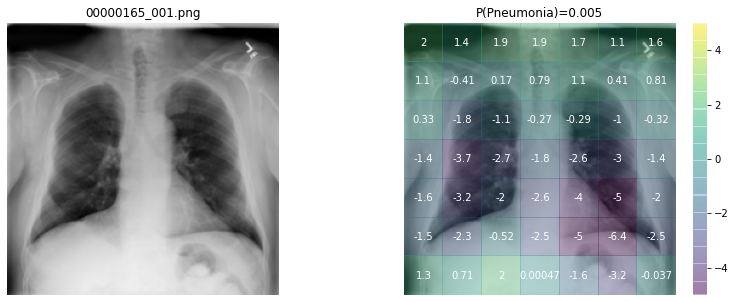

,Predicted Probability,Ground Truth
Finding,,
Infiltration,0.093,False
Nodule,0.040,False
Pleural_Thickening,0.035,False
Fibrosis,0.021,False
Atelectasis,0.020,False
Emphysema,0.019,False
Effusion,0.008,False
Mass,0.007,False
Consolidation,0.007,False


In [ ]:
preds=show_next(dataloader,model, LABEL)
preds

In [ ]:
import os
import joblib

In [ ]:
model=joblib.load('/content/drive/MyDrive/Chexnet.joblib')